In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [3]:
from torchganime.models.vqgan import VQGAN
from torchganime.models.ganime import VideoTransformer, VideoTransformerConfig
import torch
import matplotlib.pyplot as plt
from torchganime.data.dataloader.video import VideoData
from torchvision.utils import make_grid

/usr/local/lib/python3.9/dist-packages/horovod/common/util.py:258: UserWarning: Framework pytorch installed with version 1.13.0+cu117 but found version 1.13.1+cu117.
             This can result in unexpected behavior including runtime errors.
             Reinstall Horovod using `pip install --no-cache-dir` to build with the new version.
  warnings.warn(get_version_mismatch_message(name, version, installed_version))


In [4]:
vqgan = VQGAN.load_from_checkpoint("/TorchGANime/checkpoints/vqgan_full/checkpoints/epoch=199-step=168800.ckpt")

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
loaded pretrained LPIPS loss from /TorchGANime/torchganime/models/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [192]:
video_data = VideoData("/TorchGANime/data/kny/raw_videos/02.mkv", "/TorchGANime/data/kny/raw_videos/02.mkv", image_size=(128, 256), batch_size=16)

2023-01-08 14:53:33.664 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos
2023-01-08 14:53:34.891 | INFO     | torchganime.data.dataset.video:_get_video_paths:371 - Found 1 videos


In [193]:
b, target = next(iter(video_data.train_dataloader()))

In [203]:
frame_number = b["frame_number"][[0,3,4]]
first_frames = b["first_frame"][[0,3,4]]
end_frames = b["end_frame"][[0,3,4]]

In [204]:
import torchvision
grid = torchvision.utils.make_grid(first_frames)

In [205]:
first_frames.shape

torch.Size([3, 3, 128, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


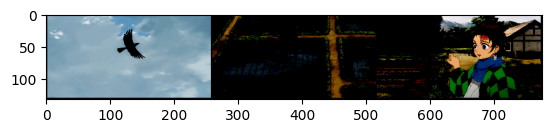

In [206]:
plt.imshow(grid.permute(1, 2, 0).detach().numpy())

In [207]:
def encode(frame):
    quant_z, _, info = vqgan.encode(frame)
    indices = info[2].view(quant_z.shape[0], -1)
    return quant_z, indices

In [208]:
first_frames_quant, first_frames_indices = encode(first_frames)
_, end_frames_indices = encode(end_frames)

In [209]:
i = 5
remaining_frames = frame_number - i

In [210]:
input = torch.stack((first_frames_indices, end_frames_indices), dim=1)

In [211]:
input.shape

torch.Size([3, 2, 512])

In [212]:
from transformers import GPT2LMHeadModel
transformer = GPT2LMHeadModel.from_pretrained("gpt2-medium")

In [213]:
logits = transformer(input).logits

In [214]:
logits.shape

torch.Size([3, 2, 512, 50257])

In [215]:
def decode_to_img(index, z_shape):
    bhwc = (z_shape[0], z_shape[2], z_shape[3], z_shape[1])
    quant_z = vqgan.quantize.get_codebook_entry(index.reshape(-1), shape=bhwc)
    x = vqgan.decode(quant_z)
    return x

In [253]:
from torch.nn import functional as F
def convert(logits):
    probs = F.softmax(logits[:, 1], dim=-1)
    _, ix = torch.topk(probs, k=1, dim=-1)
    ix = torch.squeeze(ix)
    return decode_to_img(ix, first_frames_quant.shape)

In [225]:
decoded_imgs = convert(logits)

In [226]:
decoded_imgs.shape

torch.Size([3, 3, 128, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


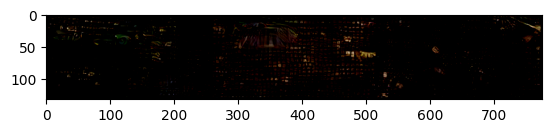

In [227]:
plt.imshow(torchvision.utils.make_grid(decoded_imgs).permute(1, 2, 0).detach().numpy())

In [242]:
position_id_end_frame = frame_number.view(1, -1).T.repeat(1, 512)
position_id_current_frame = torch.ones_like(position_id_end_frame) * i

In [246]:
position_id_end_frame.shape

torch.Size([3, 512])

In [245]:
position_id_current_frame.shape

torch.Size([3, 512])

In [249]:
position_ids = torch.stack([position_id_current_frame,position_id_end_frame], dim=1)

In [250]:
logits_positions = transformer(input, position_ids=position_ids).logits

In [254]:
decoded_imgs_positions = convert(logits_positions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


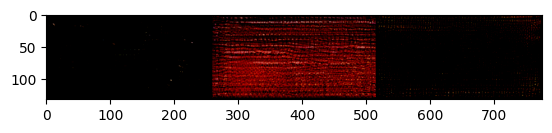

In [255]:
plt.imshow(torchvision.utils.make_grid(decoded_imgs_positions).permute(1, 2, 0).detach().numpy())

In [340]:
def get_attention_mask(transformer_input, current_frame_number, frame_number):
    # Get for each batch element a value, 0 or 1 for the padding. 1 means not padded frame, 0 means padded frame
    padded_mask = (
        (frame_number > current_frame_number).type(torch.int)
    )
    target_shape = transformer_input.shape
    # Expand the mask to the shape of the input
    return padded_mask.reshape(len(padded_mask), *(1,)*(len(target_shape)-1)).expand(target_shape).contiguous()


In [354]:
mask = get_attention_mask(input, 15, frame_number)

In [355]:
mask.shape

torch.Size([3, 2, 512])

In [359]:
logits_positions = transformer(input, position_ids=position_ids, #attention_mask=mask.contiguous()
).logits

In [360]:
decoded_imgs_mask = convert(logits_positions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


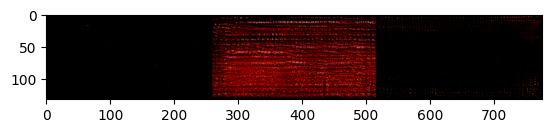

In [361]:
plt.imshow(torchvision.utils.make_grid(decoded_imgs_mask).permute(1, 2, 0).detach().numpy())

In [347]:
input.shape

torch.Size([3, 2, 512])

In [348]:
position_ids.shape

torch.Size([3, 2, 512])

In [349]:
mask.contiguous().shape

torch.Size([3, 2, 512])

In [350]:
mask

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32)